In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from model_very_simple_conv_32 import ConvNet
from tqdm import tqdm

DIR_PATH = os.getcwd() + '/../'

/vol/bitbucket/hzd21/msc_project/env_pyrep/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
demo_data = np.load(DIR_PATH + 'data/demo_reach_blue32x32_ori.npz')
for k in demo_data.keys():
    print(k, demo_data[k].shape, demo_data[k].dtype)

demo_image_sequences (187476, 32, 32, 3) uint8
demo_action_sequences (187476, 6) float64
step_marker (1359,) int64


In [3]:
n_traj = 1000
n_train = int(0.95 * n_traj)
n_val = n_traj - n_train
idx_train = demo_data['step_marker'][n_train-1]
idx_val = demo_data['step_marker'][n_traj-1]

train_imgs = demo_data['demo_image_sequences'][:idx_train]
train_act = demo_data['demo_action_sequences'][:idx_train]
val_imgs = demo_data['demo_image_sequences'][idx_train:idx_val]
val_acts = demo_data['demo_action_sequences'][idx_train:idx_val]
train_imgs.shape, train_act.shape, val_imgs.shape, val_acts.shape

((130470, 32, 32, 3), (130470, 6), (7135, 32, 32, 3), (7135, 6))

In [4]:
def mask_imgs(imgs):
    new_imgs = imgs.copy()
    for im in new_imgs:
        mask_size = np.random.randint(3, 10)
        mask_size = 5
        mask_pos = np.random.randint(0, 16-mask_size+1, 2)
        color = np.random.randint(0, 256, 3) / 255
        color=0
        im[mask_pos[0]:mask_pos[0]+mask_size, mask_pos[1]:mask_pos[1]+mask_size] = color
    return new_imgs
'''
masked1 = mask_imgs(train_imgs)
masked2 = mask_imgs(train_imgs)
masked3 = mask_imgs(train_imgs)
masked4 = mask_imgs(train_imgs)

train_x = np.concatenate([train_imgs, masked1, masked2, masked3, masked4])
train_y = np.concatenate([train_act] * 5)

v_masked1 = mask_imgs(val_imgs)

val_x = np.concatenate([val_imgs, v_masked1])
val_y = np.concatenate([val_acts] * 2)
'''

train_x = np.concatenate([train_imgs])
train_y = np.concatenate([train_act])

val_x = np.concatenate([val_imgs])
val_y = np.concatenate([val_acts])

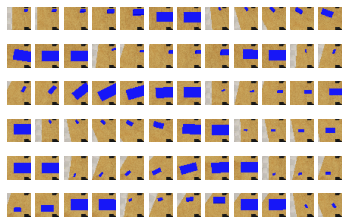

In [5]:
%matplotlib inline
for i, img_idx in enumerate(np.arange(10, 1450, 20)):
    plt.subplot(6, 12, i+1)
    plt.imshow(train_imgs[img_idx])
    plt.axis('off')

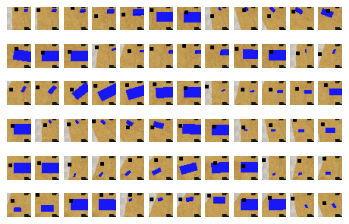

In [7]:
%matplotlib inline
for i, img_idx in enumerate(np.arange(10, 1450, 20)):
    plt.subplot(6, 12, i+1)
    plt.imshow(masked1[img_idx])
    plt.axis('off')

In [6]:
def normalize(x_data, y_data):
    normal_x = x_data / 255
    normal_y = y_data * np.array([[10, 10, 10, 100, 100, 100]])
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)

In [7]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(val_acts.shape[1]):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.0 0.8549019607843137
0.0 0.8352941176470589
0.0 0.9686274509803922
-0.5829259906455122 0.9682569492013658
-0.9798691016004167 0.983695414432515
-0.9999939373750286 0.7544532253097108
-0.353233171428491 0.3730877523671495
-0.7874769483985133 0.9997969888916325
-0.9999999715133332 1.0000000122958332


In [12]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)

train_set.x.shape, train_set.y.shape, v_set.x.shape, v_set.y.shape

(torch.Size([130470, 3, 32, 32]),
 torch.Size([130470, 6]),
 torch.Size([7135, 3, 32, 32]),
 torch.Size([7135, 6]))

In [13]:
model = ConvNet(n_classes=6)
#model = MLP(layers_dim=(16*16*3, 16, 3))
print('MODEL INFO:', model, sep='\n')
sum_total_learnable_params = 0
for param in model.parameters():
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)
Number of learnable paramete

In [14]:
def train(model, train_set, v_set, lr, bs, stop_criterion, max_epochs, model_name='current_model', device_name='cuda:0'):
    train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, drop_last=True)
    device = torch.device('cuda:0')
    model.to(device)
    vx, vy = v_set.x.to(device), v_set.y.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}
    best_v_loss = np.inf
    stop_counter = 0

    for epoch in range(max_epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description(f'Epoch {epoch}/{max_epochs} max ; best_vloss={best_v_loss:.6f}')
            for (x, y) in tepoch:
                model.train()
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                tepoch.set_postfix_str(f'loss={loss.item():.6f}', refresh=False)

            model.eval()
            with torch.no_grad():
                loss_logger['loss'].append(loss.item())
                loss_per_class = ((y - y_pred)**2).mean(axis=0).cpu().numpy()
                loss_logger['loss_class'].append(loss_per_class)
                vy_pred = model.forward(vx)
                v_loss_per_class = ((vy - vy_pred)**2).mean(axis=0).cpu().numpy()
                v_loss = v_loss_per_class.mean().item()
                loss_logger['vloss'].append(v_loss)
                loss_logger['vloss_class'].append(v_loss_per_class)
                if v_loss < best_v_loss:
                    best_v_loss = v_loss
                    stop_counter = 0
                    torch.save(model.state_dict(), f'{DIR_PATH}/data/{model_name}.pth')
                else:
                    stop_counter += 1
                    if stop_counter > stop_criterion:
                        print('Early stopping')
                        break

    return loss_logger

In [15]:
model = ConvNet(n_classes=6)
loss_log = train(model, train_set, v_set, lr=0.0005, bs=512, stop_criterion=20, max_epochs=500)

Epoch 285/500 max ; best_vloss=0.002277: 100%|██████████| 254/254 [00:03<00:00, 75.02batch/s, loss=0.001535]

Early stopping


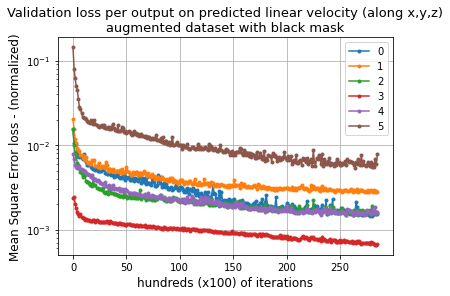

In [16]:
plt.plot(np.stack(loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("Validation loss per output on predicted linear velocity (along x,y,z)\naugmented dataset with black mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.legend(range(6))
plt.grid()

(0.0, 300.0)

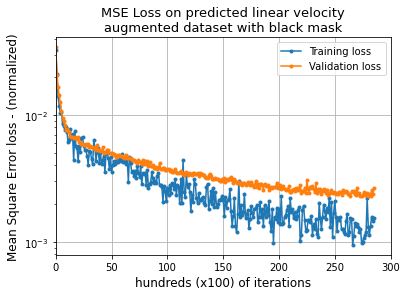

In [22]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\naugmented dataset with black mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlim(0, 300)

In [44]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_conv_very_simple_32_200ep_no_mask_v_xyzabg.pth')

In [46]:
vloss = np.array(loss_log['vloss'])

In [69]:
lm = np.inf
c = 0
cm = 10
for i, l in enumerate(vloss[0::3]):
    if l < lm:
        lm = l
        c = 0
    else:
        c += 1
        if c >= cm:
            print(i, l)

70 0.021645767614245415
71 0.0214192196726799
72 0.021399566903710365
73 0.02158392034471035
74 0.02143412083387375
75 0.021778186783194542
76 0.02154570072889328
112 0.021139631047844887
113 0.02117224782705307
114 0.021132759749889374
115 0.021311908960342407
116 0.021327950060367584
117 0.021243274211883545
118 0.02126595936715603
119 0.021271182224154472
120 0.021385885775089264
121 0.02137349545955658
122 0.02129463292658329
123 0.021155910566449165
124 0.021169187501072884
125 0.021191760897636414
126 0.021369317546486855
127 0.021336471661925316
128 0.021174965426325798
129 0.021158302202820778
130 0.02117331512272358
151 0.02109713666141033
152 0.021245038136839867
153 0.02122821845114231
154 0.021110624074935913
155 0.021165350452065468
156 0.021143026649951935


In [33]:
loss_log2 = train(model, train_set, v_set, n_epochs=100, lr=0.000001, bs=256)

Starting epoch 0/100 vloss 0.0019676736555993557
Starting epoch 1/100 vloss 0.0029659701976925135
Starting epoch 2/100 vloss 0.0014690925600007176
Starting epoch 3/100 vloss 0.002079324098303914


KeyboardInterrupt: 

In [28]:
plt.plot(loss_log2['loss'], '.-', label='Training loss')
plt.plot(loss_log2['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

{'loss': [0.001793750561773777,
  0.0015320581151172519,
  0.0010418338933959603,
  0.0014600249705836177,
  0.001935905427671969,
  0.0014906803844496608,
  0.0015694801695644855,
  0.0009527709917165339,
  0.001360985916107893,
  0.002140719210729003,
  0.0017441143281757832,
  0.0010749396169558167,
  0.0019036238081753254,
  0.0016842433251440525,
  0.0017658458091318607,
  0.001609841943718493,
  0.0012018801644444466,
  0.0014155032113194466,
  0.0014100180706009269,
  0.0022631098981946707,
  0.002136577619239688,
  0.002163921482861042,
  0.001270182547159493,
  0.0011121287243440747,
  0.001132398727349937,
  0.0015542347682639956,
  0.0013297341065481305,
  0.0012512755347415805,
  0.0010872194543480873,
  0.0010764370672404766,
  0.0010807079961523414,
  0.0011795194586738944,
  0.001240202342160046,
  0.0013623759150505066,
  0.0027512505184859037,
  0.0012995828874409199,
  0.0013015512377023697,
  0.001553389709442854,
  0.002027802634984255,
  0.0015548485098406672,
  0.

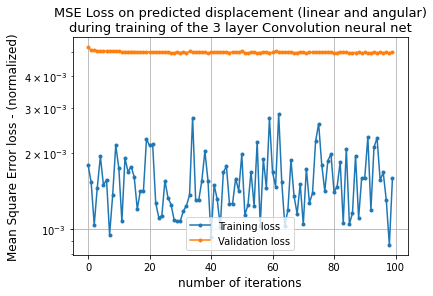

In [30]:
plt.plot(loss_log2['loss'], '.-', label='Training loss')
plt.plot(loss_log2['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

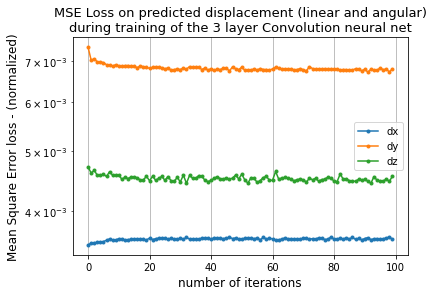

In [31]:
plt.plot(np.stack(loss_log2['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

In [34]:
nomask_train_x = np.concatenate([train_imgs, train_imgs, train_imgs])

In [35]:
nomask_train_set = DemoDataset(nomask_train_x, normal_train_y)

In [36]:
model = ConvNet(n_classes=3)
nomask_loss_log = train(model, nomask_train_set, v_set, n_epochs=100, lr=0.0001, bs=256)

Starting epoch 0/100 vloss 0.24703292548656464
Starting epoch 1/100 vloss 0.09479860216379166
Starting epoch 2/100 vloss 0.025909140706062317
Starting epoch 3/100 vloss 0.012658781372010708


KeyboardInterrupt: 

In [ ]:
plt.plot(nomask_loss_log['loss'], '.-', label='Training loss')
plt.plot(nomask_loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\nduring training of a 3 layer convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

In [ ]:
plt.plot(np.stack(nomask_loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("Validation loss per output on predicted linear velocity (along x,y,z)", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.legend(('x', 'y', 'z'))
plt.grid()

In [ ]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_conv_simple_100ep_50_16x16_nomask_multicolor_placebo_v_xyz.pth')

In [37]:
# Futher train model
model200 = ConvNet(n_classes=3)
loss_log200 = train(model, train_set, v_set, n_epochs=200, lr=0.0001, bs=256)

Starting epoch 0/200 vloss 0.03940765932202339
Starting epoch 1/200 vloss 0.025015009567141533
Starting epoch 2/200 vloss 0.023801719769835472
Starting epoch 3/200 vloss 0.018592458218336105
Starting epoch 4/200 vloss 0.017218438908457756
Starting epoch 5/200 vloss 0.015232793986797333
Starting epoch 6/200 vloss 0.01256983820348978
Starting epoch 7/200 vloss 0.011351756751537323
Starting epoch 8/200 vloss 0.011945423670113087
Starting epoch 9/200 vloss 0.009802657179534435
Starting epoch 10/200 vloss 0.012764200568199158
Starting epoch 11/200 vloss 0.013890046626329422
Starting epoch 12/200 vloss 0.010943601839244366
Starting epoch 13/200 vloss 0.008660252206027508
Starting epoch 14/200 vloss 0.010016005486249924
Starting epoch 15/200 vloss 0.009342162869870663
Starting epoch 16/200 vloss 0.009831818751990795
Starting epoch 17/200 vloss 0.008190003223717213
Starting epoch 18/200 vloss 0.007936239242553711
Starting epoch 19/200 vloss 0.00948874931782484
Starting epoch 20/200 vloss 0.007

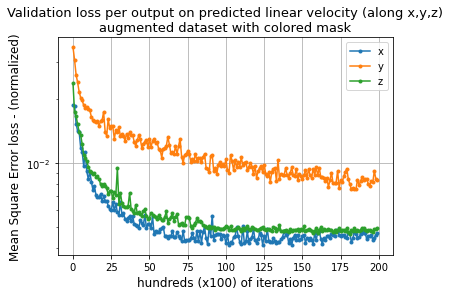

In [42]:
plt.plot(np.stack(loss_log200['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("Validation loss per output on predicted linear velocity (along x,y,z)\naugmented dataset with colored mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.legend(('x', 'y', 'z'))
plt.grid()

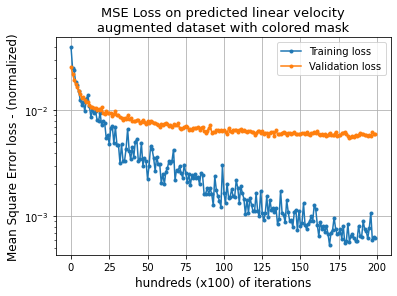

In [44]:
plt.plot(loss_log200['loss'], '.-', label='Training loss')
plt.plot(loss_log200['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\naugmented dataset with colored mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()